# Capstone Project Data Wrangling

## Predicting Turbofan Engine Failure Based on Sensor Output

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pandas.plotting import scatter_matrix
from sklearn import linear_model

from sklearn import model_selection
import sklearn.tree
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.metrics import max_error
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [2]:
# load
%load_ext pycodestyle_magic

In [3]:
%pycodestyle_off

## Import Training Data

The data given is split up into testing data, training data, and vectors of remaining useful life (RUL) corresponding to each engine ID. There are four different sets of data for each category (testing, training, etc.) and each set differs by operating conditions and fault modes, where sets one and three are at sea level with one fault mode, and two and four have six different operating conditions contained in them with two fault modes. 

For now, each set is imported and treated for NaNs and missing data. Since the data was taken from simulation, there is no missing data along the rows, but sensors 22 and 23 (s22 and s23) were NaN for all time and thus removed.

In [4]:
col_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 'T2', 'T24', 'T30', 'T50',
             'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR',
             'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32', 's22', 's23']

1:80: E501 line too long (90 > 79 characters)
2:80: E501 line too long (87 > 79 characters)
3:80: E501 line too long (82 > 79 characters)


In [5]:
df_train1 = pd.read_csv('train_FD001.txt', sep=' ', header=None)
df_train2 = pd.read_csv('train_FD002.txt', sep=' ', header=None)
df_train3 = pd.read_csv('train_FD003.txt', sep=' ', header=None)
df_train4 = pd.read_csv('train_FD004.txt', sep=' ', header=None)

In [6]:
df_train1.columns = col_names
df_train2.columns = col_names
df_train3.columns = col_names
df_train4.columns = col_names

In [7]:
df_train1_no_na = df_train1.drop(columns=['s22', 's23'])
df_train2_no_na = df_train2.drop(columns=['s22', 's23'])
df_train3_no_na = df_train3.drop(columns=['s22', 's23'])
df_train4_no_na = df_train4.drop(columns=['s22', 's23'])
df_train1_no_na

,id,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


The average number of cycles per engine is 108. Each engine in the training set is driven until failure, thus the final value of each feature for each engine represents the feature value at engine failure.

In [8]:
df_train1_no_na.describe()

,id,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [9]:
df_train1_no_na.isnull().sum()

id           0
cycle        0
setting1     0
setting2     0
setting3     0
T2           0
T24          0
T30          0
T50          0
P2           0
P15          0
P30          0
Nf           0
Nc           0
epr          0
Ps30         0
phi          0
NRf          0
NRc          0
BPR          0
farB         0
htBleed      0
Nf_dmd       0
PCNfR_dmd    0
W31          0
W32          0
dtype: int64

In [10]:
train4_id = df_train4_no_na.id.unique()
print(train4_id)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

### Preliminary Data Plotting

We can see that for set one, there is a montonically increasing or decreasing trend among these features as the engine wears. Since sensor noise was simulated, it can be cleaned by taking a rolling average or by applying a filter.

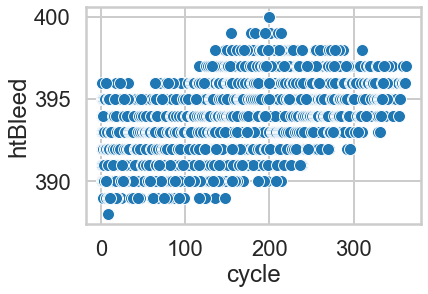

In [11]:
sns.scatterplot(data=df_train1_no_na, x='cycle', y='htBleed')
plt.title('Bleed Enthalpy (htBleed) vs Cycles')
plt.show()

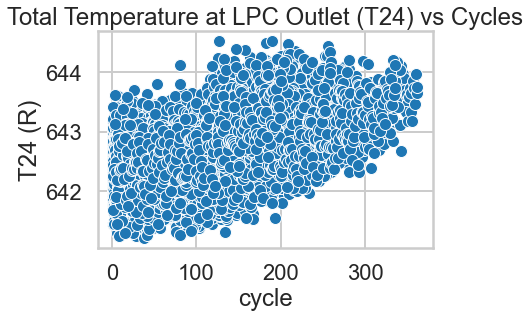

In [25]:
sns.scatterplot(data=df_train1_no_na, x='cycle', y='T24')
plt.title('Total Temperature at LPC Outlet (T24) vs Cycles')
plt.ylabel('T24 (R)')
plt.show()

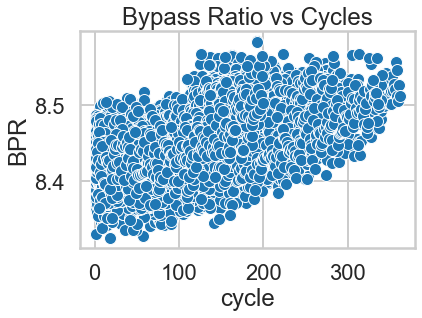

In [24]:
sns.scatterplot(data=df_train1_no_na, x='cycle', y='BPR')
plt.title('Bypass Ratio (BPR) vs Cycles')
plt.ylabel('BPR (psia)')
plt.show()

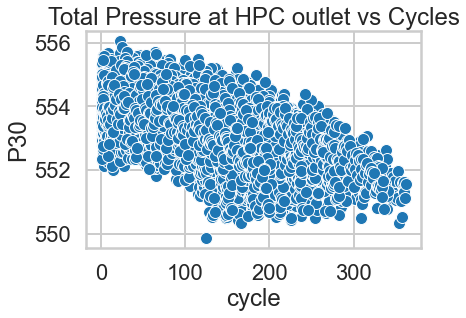

In [14]:
sns.scatterplot(data=df_train1_no_na, x='cycle', y='P30')
plt.title('Total Pressure at HPC Outlet (P30) vs Cycles')
plt.ylabel('P30 (psia)')
plt.show()

Text(0.5, 1.0, 'Standard Deviation of Features')

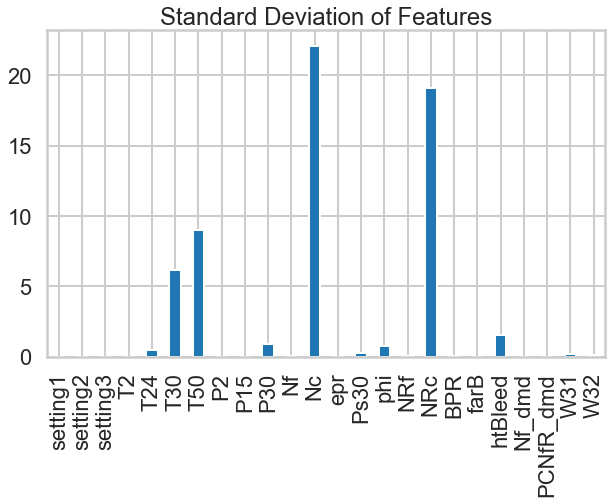

In [15]:
cols = df_train1_no_na.columns[2:]
df_train1_no_na[cols].std().plot(kind='bar', figsize=(10, 6))
plt.title('Standard Deviation of Features')

## Import Test Data

The same treatment is given to test data to remove NaN values and columns.

In [16]:
df_test1 = pd.read_csv('test_FD001.txt', sep=' ', header=None)
df_test2 = pd.read_csv('test_FD002.txt', sep=' ', header=None)
df_test3 = pd.read_csv('test_FD003.txt', sep=' ', header=None)
df_test4 = pd.read_csv('test_FD004.txt', sep=' ', header=None)

In [17]:
df_test1.columns = col_names
df_test2.columns = col_names
df_test3.columns = col_names
df_test4.columns = col_names

In [18]:
df_test_no_na1 = df_test1.drop(columns=['s22', 's23'])
df_test_no_na2 = df_test2.drop(columns=['s22', 's23'])
df_test_no_na3 = df_test3.drop(columns=['s22', 's23'])
df_test_no_na4 = df_test4.drop(columns=['s22', 's23'])
df_test_no_na1.head()

,id,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [19]:
df_test_no_na1.isnull().sum()

id           0
cycle        0
setting1     0
setting2     0
setting3     0
T2           0
T24          0
T30          0
T50          0
P2           0
P15          0
P30          0
Nf           0
Nc           0
epr          0
Ps30         0
phi          0
NRf          0
NRc          0
BPR          0
farB         0
htBleed      0
Nf_dmd       0
PCNfR_dmd    0
W31          0
W32          0
dtype: int64

In the test set for set one, the average engine cycle count was 76.83 with a standard deviation of 28.28. The engines in the test set are not run until failure, unlike the training set. A separate RUL vector is provided for the test engines.

In [26]:
df_test_no_na1.describe()

,id,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,1.309600e+04,13096.000000,13096.000000,13096.000000,1.309600e+04,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,100.0,5.186700e+02,642.475088,1588.099204,1404.735362,1.462000e+01,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.0,6.014263e-11,0.400899,5.003274,6.688309,2.671743e-12,...,0.559627,0.056934,10.188605,0.029009,8.823140e-15,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,100.0,5.186700e+02,641.130000,1569.040000,1384.390000,1.462000e+01,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.197500,1584.600000,1399.950000,1.462000e+01,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,52.000000,69.000000,0.000000,0.000000,100.0,5.186700e+02,642.460000,1587.990000,1404.440000,1.462000e+01,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,100.0,5.186700e+02,642.740000,1591.362500,1409.050000,1.462000e+01,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,100.0,5.186700e+02,644.300000,1607.550000,1433.360000,1.462000e+01,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


## Import Remaining Useful Life (RUL) Data

RUL data is imported and the empty column is dropped. RUL is for the engines in the test set.

In [28]:
df_rul1 = pd.read_csv('RUL_FD001.txt', sep=' ', header=None)
df_rul2 = pd.read_csv('RUL_FD002.txt', sep=' ', header=None)
df_rul3 = pd.read_csv('RUL_FD003.txt', sep=' ', header=None)
df_rul4 = pd.read_csv('RUL_FD004.txt', sep=' ', header=None)

In [29]:
col_names = ['remaining_useful_life', 'NaNs']

df_rul1.columns = col_names
df_rul2.columns = col_names
df_rul3.columns = col_names
df_rul4.columns = col_names

df_rul1 = df_rul1.drop(columns=['NaNs'])
df_rul2 = df_rul2.drop(columns=['NaNs'])
df_rul3 = df_rul3.drop(columns=['NaNs'])
df_rul4 = df_rul4.drop(columns=['NaNs'])

df_real1

,remaining_useful_life
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


Average RUL among the engines in set one is 75.52 cycles with a standard deviation of 41.76.

In [30]:
df_rul1.describe()

,remaining_useful_life
count,100.00000
mean,75.52000
std,41.76497
min,7.00000
25%,32.75000
50%,86.00000
75%,112.25000
max,145.00000


In [31]:
df_rul1.isnull().sum()

remaining_useful_life    0
dtype: int64